#### This file contains code used to generate the results in the paper "Towards Cognitively-Faithful Decision-Making Models to Improve AI Alignment".

In [1]:
%load_ext autoreload
%autoreload 2
    
from importlib import reload
import numpy as np
import dataset
from dataset import *

from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import seaborn as sns
import scipy

from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import copy
from functools import *
import choix
import matplotlib.pyplot as plt
import itertools
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.calibration import LinearSVC
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings("ignore")

from helpers import *
from functools import partial
from multiprocess import Pool

import pygam


In [2]:
study = "one" #choices here include "one", "two", or "simulated". 
#Choices "one" and "two" correspond to the real-world dataset and  "simulated" corresponds to the synthetic dataset - see paper for more details

In [3]:
### Dataset and feature details

from dataset import *

df = get_data(study)
idvar = "uid" if study=="one" else "id"

if study=="one":
    feat_cols = ['uid', 'lalco', 'ldep', 'llife', 'lcrim', 'ralco', 'rdep', 'rlife', 'rcrim', 'chosen', 
                 'alcodiff', 'depdiff', 'lifediff', 'crimdiff', 'secElasped', 'pairid']
    diffcols = ['lifediff', 'crimdiff', 'alcodiff', 'depdiff']
    main_cols = ['alco', 'dep', 'life', 'crim']

if study=="two":
    feat_cols = ['id', 'l_elderlyDep', 'l_lifeYearsGained', 'l_obesity', 'l_weeklyWorkhours', 'l_yearsWaiting', 
                 'r_elderlyDep', 'r_lifeYearsGained', 'r_obesity', 'r_weeklyWorkhours', 'r_yearsWaiting', 
                 'eldepdiff', 'lifediff', 'obesdiff', 'workdiff', 'waitdiff', 'chosen', 'secElasped', 'pairid']
    diffcols = ['eldepdiff', 'lifediff', 'obesdiff', 'workdiff', 'waitdiff']
    main_cols = ['elderlyDep', 'lifeYearsGained', 'obesity', 'weeklyWorkhours', 'yearsWaiting']

if study=="simulated":
    main_cols = ['dependents', 'life_gained', 'years_waiting', 'crimes']
    feat_values = {'dependents': list(range(6)),  
                'life_gained': list(range(1,30, 5)), 
                'years_waiting': list(range(1,11)),
                'crimes': list(range(4))}

if study in ["one", "two"]:
    if study == "one":
        repids = ['easy1', 'easy2', 'easy3', 'hard1', 'hard2', 'hard3']
    else:
        repids = ['easy_1', 'easy_2', 'easy_3', 'hard_1', 'hard_2', 'hard_3']

    df = df[~df.pairid.isin(repids)]

    df_lim = df[feat_cols]
    if study == "one":
        df_lim = df_lim[df_lim.llife != -1]
        df_lim = df_lim[df_lim.rlife != -1]

    if study == "two":
        df_lim = df_lim[df_lim.l_lifeYearsGained != -1]
        df_lim = df_lim[df_lim.r_lifeYearsGained != -1]

        # df_lim.l_obesity = np.abs(df_lim.l_obesity)
        # df_lim.r_obesity = np.abs(df_lim.r_obesity)
        # df_lim.obesdiff = df_lim.l_obesity - df_lim.r_obesity
else:
    df_lim = df

users = df_lim[idvar].unique()


In [4]:
ls = []
for user in users:
    ls.append(len(df_lim[df_lim[idvar] == user]))

# Average number of responses per decision-maker
np.mean(ls), len(users)

# df

(383.46666666666664, 15)

In [5]:
## additional details on the dataset and feature properties
lprefix = "l" if study=="one" else "l_"
rprefix = "r" if study=="one" else "r_"
feature_values = {}
for f in main_cols:
    feature_values[f] = sorted(df_lim[lprefix+f].unique())
print (feature_values)


if study == "one":
    feature_signs = {'alco':-1, 'dep':1, 'life':1, 'crim':-1}
    feat_to_diff_feat = {'alco':'alcodiff', 'dep':'depdiff', 'life':'lifediff', 'crim':'crimdiff'}
elif study == "two":
    feature_signs = {'elderlyDep':1, 'lifeYearsGained':1, 'obesity':-1, 'weeklyWorkhours':1, 'yearsWaiting':1}        
    feat_to_diff_feat = {'elderlyDep':'eldepdiff', 'lifeYearsGained':'lifediff', 'obesity':'obesdiff', 'weeklyWorkhours':'workdiff', 'yearsWaiting':'waitdiff'}
else:
    feature_signs = {'age':1, 'dependents':1, 'life_gained':1, 'years_waiting':1, 'crimes':-1}



{'alco': [0, 2, 4], 'dep': [0, 1, 2], 'life': [1, 2, 3], 'crim': [0, 1, 2]}


### Learning our model and baselines over the entire dataset

In [6]:
from baseline_utils import *
import warnings
warnings.filterwarnings("ignore")

In [7]:
baseline_models = {
            'ElasticNet': LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5),
            'DecisionTreeClassifier': DecisionTreeClassifier(),
            'RandomForestClassifier': RandomForestClassifier(),
            'MLPClassifier': MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000),
            'LinearSVC': LinearSVC(),
            'kNN': KNeighborsClassifier(),
            'GAM': pygam.LogisticGAM(gam_terms_by_study[study])
    }

In [10]:
def run_user_rep(user, df_user, interactions, verbose, baseline_models, loss, rep):

    df_user_train, df_user_test = train_test_split(df_user, test_size=0.3, shuffle=True, random_state=rep)
    df_user_train, df_user_val = train_test_split(df_user_train, test_size=2/7, shuffle=False)

    cols = [lprefix+c for c in main_cols] + [rprefix+c for c in main_cols]

    results = []
    for name, model in baseline_models.items():
        try:
            model.fit(df_user_train[cols], df_user_train['chosen'])
            acc = model.score(df_user_test[cols], df_user_test['chosen'])
            results.append([rep, user, name, acc, None])
        except:
            continue

        if verbose:
            print (rep, user, name, acc)

    model = LGClassifier(cols=main_cols, prefixes=[lprefix, rprefix], verbose=False)
    model.fit(df_user_train)
    lg_acc = model.score(df_user_test)
    results.append([rep, user, "Logistic Clf", lg_acc, model])

    ddm_acc = get_ddm_model_performance(df_user_train, df_user_test, study)
    results.append([rep, user, "DDM model", ddm_acc, None])

    bt_acc = get_BT_model_performance(df_user_train, df_user_test, lprefix, rprefix, main_cols)
    results.append([rep, user, "BT model", bt_acc, None])

    if verbose:
        print (rep, user, "Linear model - test acc", lg_acc)
        print (rep, user, "DDM model", ddm_acc)
        print (rep, user, "BT model", bt_acc, "\n")

    # ### old method for conditional feature selection - replaced by CV selection now
    # main_features = sorted(model.coefs, key=lambda x: np.abs(model.coefs[x]), reverse=True) 
    # cond_feature = sorted(model.coefs, key=lambda x: np.abs(model.coefs[x]), reverse=True)[0]
    # ###


    train_accs, test_accs, fmodels = [], [], []
    main_features = main_cols[:1]
    # main_features = ['dep']  ##when running for a fixed context

    for cond_feature in main_features:
        # params = {'lambda2': np.linspace(0, 0.01, 10)}
        params = {'lambda1': np.linspace(0, 0.001, 10), 'lambda2': np.linspace(0, 0.01, 10)}
        
        model = IsotonicFactorClassifier(interactions=interactions, cols=main_cols, 
                                                        feature_signs=feature_signs, feature_values=feature_values, feat_to_diff_feat=feat_to_diff_feat,
                                                        lambda1=.000, lambda2=0.000, 
                                                        cond_feature=cond_feature, prefixes=[lprefix, rprefix], loss=loss, verbose=False)

        # model = RandomizedSearchCV(model, params, cv=5, verbose=0)
        # model = GridSearchCV(model, params, cv=5, verbose=0)
        model.fit(df_user_train)
        # print (model.best_params_)
        test_acc = model.score(df_user_test)
        train_acc = model.score(df_user_val)

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        fmodels.append(model)

    acc = test_accs[np.argmax(train_accs)]         

    if verbose:
        print (rep, user, "Two-stage model", acc, "\n")
    results.append([rep, user, "Our two-Stage model", acc, fmodels[np.argmax(train_accs)]])

    return results


In [11]:
verbose = False
run_parallel = False
loss = "logistic" # or "hinge"
interactions = False  ## whether or not feature interactions are to be considered in our model
# results in the paper use interactions=True for real-world datasets (study="one" or "two") and interactions=False for synthetic dataset (study="simulated")

all_outputs = []
reps = 5

for user in tqdm(users):
    df_user = df_lim[df_lim[idvar]==user]   

    if run_parallel:
        func = partial(run_user_rep, user, df_user, interactions, verbose, baseline_models, loss)
        max_pool = 5
        with Pool(max_pool) as p:
            pool_outputs = list(p.imap(func, range(reps)))                
        all_outputs += pool_outputs

    else:
        for rep in range(reps):
            all_outputs += run_user_rep(user, df_user, interactions, verbose, baseline_models, loss, rep)


results = np.array(all_outputs).reshape((len(all_outputs)*11, 5)) if run_parallel else np.array(all_outputs)

  0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
results = np.array(all_outputs).reshape((len(all_outputs)*1, 5)) if run_parallel else np.array(all_outputs)
#  
res_df = pd.DataFrame(results[:, :4], columns=["rep", "User", "Model Name", "Accuracy"])
print (res_df["Model Name"].value_counts())
ys = res_df[res_df["Model Name"]=="Our two-Stage model"]["Accuracy"]
np.mean(ys), np.std(ys)

Model Name
Our two-Stage model    75
Name: count, dtype: int64


(0.9053864928117857, 0.06409726404470634)

Our two-Stage model 0.9053864928117858 0.06409726404470635


(0.45, 1.05)

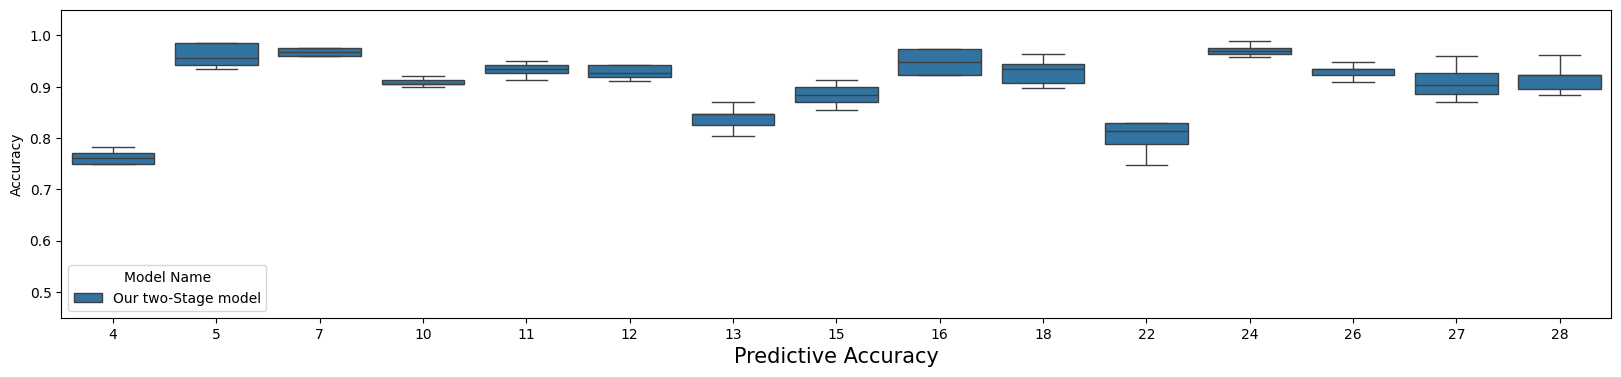

In [13]:

res_df = pd.DataFrame(results[:, :4], columns=["rep", "User", "Model Name", "Accuracy"])
# res_df = pd.read_csv('output/study_one_results_all_methods.csv')
res_df["Accuracy"] = res_df["Accuracy"].astype(float)
res_df["User"] = res_df["User"].astype(int)
res_df = res_df.sort_values(by=['User'])

### Aggregated performance for all methods

for name in res_df["Model Name"].unique():
    subdf = res_df[res_df["Model Name"]==name]
    print (name, np.mean(subdf["Accuracy"]), np.std(subdf["Accuracy"]))

plt.figure(figsize=(20, 4))

ms = ['Our two-Stage model', 'Logistic Clf', 'MLPClassifier']
sns.boxplot(x="User", y="Accuracy", hue="Model Name", data=res_df[res_df['Model Name'].isin(ms)], showfliers=False)
plt.xlabel("Participant ID", fontsize=15)
plt.xlabel("Predictive Accuracy", fontsize=15)
plt.ylim(0.45, 1.05)

# plt.savefig("images/study_"+study+"_factor_vs_baselines.png", bbox_inches='tight')

In [377]:
# res_df.to_csv('output/study_'+study+"_results_all_methods.csv")
# res_df.to_csv('output/results_simulated_dms.csv')

(0.45, 1.05)

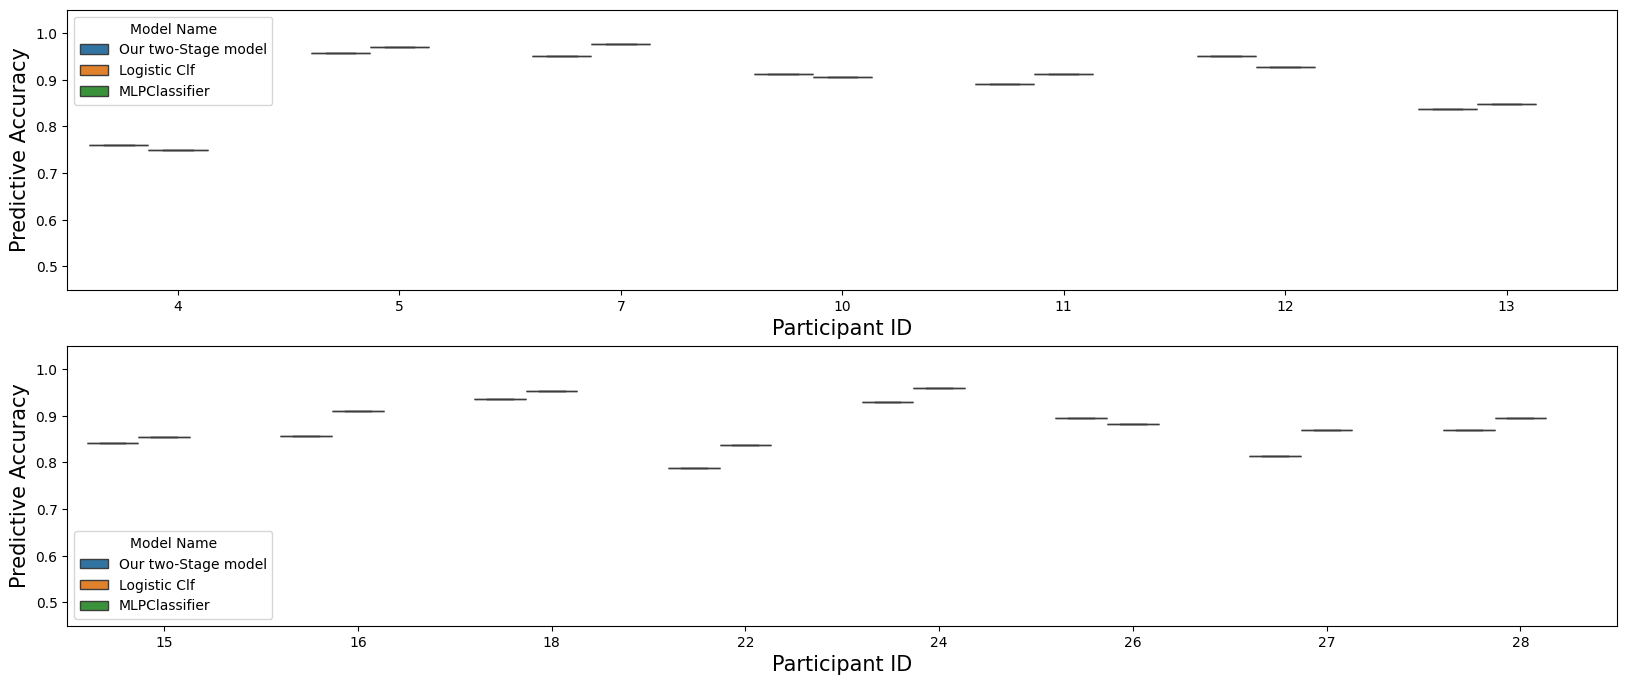

In [17]:

res_df = pd.DataFrame(results[:, :4], columns=["rep", "User", "Model Name", "Accuracy"])
res_df["Accuracy"] = res_df["Accuracy"].astype(float)
res_df["User"] = res_df["User"].astype(int)
res_df = res_df.sort_values(by=['User'])

users = np.unique(res_df["User"])
plt.figure(figsize=(20, 8))
hue_order = ['Our two-Stage model', 'Logistic Clf', 'MLPClassifier']

plt.subplot(211)
res_df1 = res_df[res_df["User"].isin(users[:int(len(users)/2)])]
sns.boxplot(x="User", y="Accuracy", hue="Model Name", data=res_df1[res_df1['Model Name'].isin(hue_order)], hue_order=hue_order, showfliers=False)
plt.xlabel("Participant ID", fontsize=15)
plt.ylabel("Predictive Accuracy", fontsize=15)
plt.ylim(0.45, 1.05)


plt.subplot(212)
res_df2 = res_df[res_df["User"].isin(users[int(len(users)/2):])]
sns.boxplot(x="User", y="Accuracy", hue="Model Name", data=res_df2[res_df2['Model Name'].isin(hue_order)], hue_order=hue_order, showfliers=False)
plt.xlabel("Participant ID", fontsize=15)
plt.ylabel("Predictive Accuracy", fontsize=15)
plt.ylim(0.45, 1.05)

# plt.savefig("images/study_"+study+"_factor_vs_baselines.png", bbox_inches='tight')

In [68]:
factors_by_user = {user: [] for user in users}
for row in results:
    user = row[1]
    mn = row[2]
    if mn != 'Our two-Stage model':
        continue
    model = row[4]
    factors_by_user[user].append(model)


### Decision Rules for Participant 4 of Study One

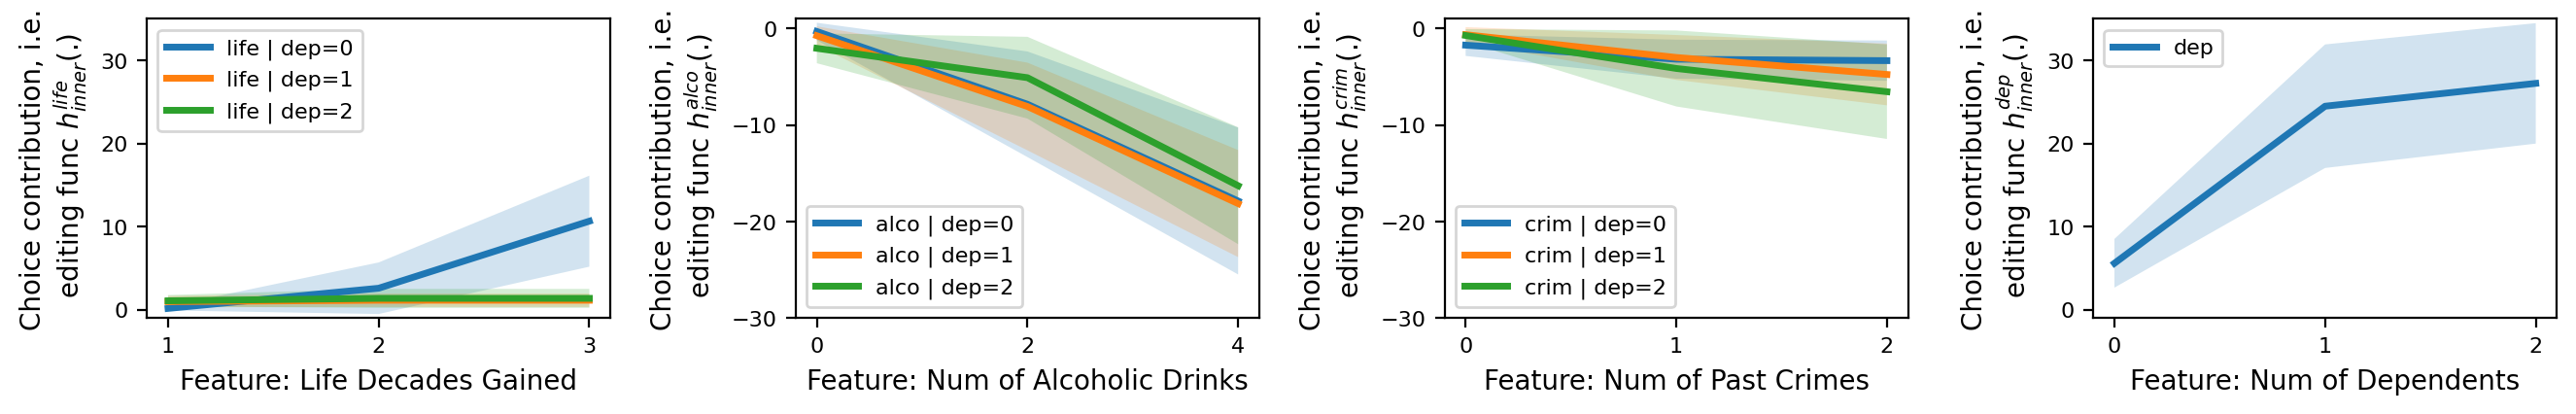

In [32]:
userID = 4
mean_model = copy.deepcopy(factors_by_user[userID][0])
std_model = copy.deepcopy(factors_by_user[userID][0])

for hrule in mean_model.ir:
    fname = hrule.fname
    vals = []
    for model in factors_by_user[userID]:
        
        for r in model.ir:
            if r.fname == fname:
                vals.append(list(r.get_vars()))
            else:
                continue

    mean_vals = np.mean(vals, axis=0)
    hrule.rule = dict(zip(hrule.fvalues, mean_vals))

for hrule in std_model.ir:
    fname = hrule.fname
    vals = []
    for model in factors_by_user[userID]:
        
        for r in model.ir:
            if r.fname == fname:
                vals.append(list(r.get_vars()))
            else:
                continue

    std_vals = np.std(vals, axis=0)
    hrule.rule = dict(zip(hrule.fvalues, std_vals))
    
plt.figure(figsize=(16, 2), dpi=200)

feat_to_print_names = {'life': 'Life Decades Gained', 'alco': 'Num of Alcoholic Drinks','crim': 'Num of Past Crimes',  'dep': 'Num of Dependents'}

k=0
feat_to_rules_mean = {feat: [] for feat in feat_to_print_names.keys()}
feat_to_rules_std = {feat: [] for feat in feat_to_print_names.keys()}

for i, feat in enumerate(feat_to_print_names.keys()):
    for rule in mean_model.ir:
        if feat == rule.fname.split(" | ")[0]:
            feat_to_rules_mean[feat].append(rule)
    for rule in std_model.ir:
        if feat == rule.fname.split(" | ")[0]:
            feat_to_rules_std[feat].append(rule)

for i, feat in enumerate(feat_to_print_names.keys()):
    ax = plt.subplot(1,len(main_cols), i+1)
    for j in range(len(feature_values[feat])):
        if j >= len(feat_to_rules_mean[feat]):
            break
        rule = feat_to_rules_mean[feat][j]
        vars_mean = rule.fsign * np.array(rule.get_vars())
        ax.plot(rule.fvalues, vars_mean, label=rule.fname, linewidth=2.5)

        rule = feat_to_rules_std[feat][j]
        vars_std = np.array(rule.get_vars())
        ax.fill_between(rule.fvalues, vars_mean-vars_std, vars_mean+vars_std, alpha=0.2)
        

        ax.legend()
        k += 1       

    if feature_signs[feat] == 1:
        ax.set_ylim(-1, 35) 
        ax.legend(loc='upper left', fontsize=8)
    else:
        ax.set_ylim(-30, 1)
        ax.legend(loc='lower left', fontsize=8)

    ax.set_xticks(feature_values[feat])
    inner = "inner"
    ax.set_xlabel("Feature: "+ feat_to_print_names[feat], fontsize=10)
    ax.set_ylabel("Choice contribution, i.e.\n editing func $h_{{inner}}^{%s}$(.)" %feat, fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    
plt.subplots_adjust(wspace=0.4)
# plt.savefig('images/p4_factors.png', bbox_inches='tight')


### Decision Rules for Simulated Decision Maker DM1

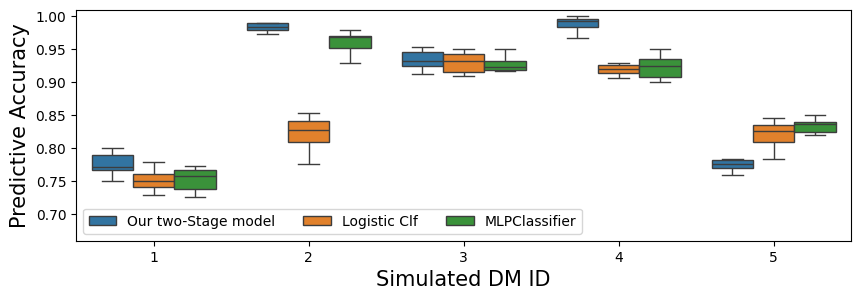

In [96]:
uss = []
for uid in range(1,6):
    uss.append([[j, uid] for j in np.array(list(range(10)))*10 + uid])

uss = np.array(uss).flatten().reshape(50, 2)
uss = dict(uss)
res_df = pd.DataFrame(results[:, :4], columns=["rep", "User", "Model Name", "Accuracy"])

res_df["Simulated DM ID"] = res_df["User"].apply(lambda x: uss[x])
res_df["Accuracy"] = res_df["Accuracy"].astype(float)
res_df["User"] = res_df["User"].astype(int)
res_df = res_df.sort_values(by=['Simulated DM ID'])

plt.figure(figsize=(10, 3))

ms = ['Our two-Stage model', 'Logistic Clf', 'MLPClassifier']
sns.boxplot(x="Simulated DM ID", y="Accuracy", hue="Model Name", data=res_df[res_df['Model Name'].isin(ms)], showfliers=False)
plt.xlabel("Simulated DM ID", fontsize=15)
plt.ylabel("Predictive Accuracy", fontsize=15)
plt.ylim(0.66, 1.01)
plt.legend(ncol=3)

# plt.savefig("images/study_"+study+"_factor_vs_baselines.png", bbox_inches='tight')


<Figure size 2600x1000 with 0 Axes>

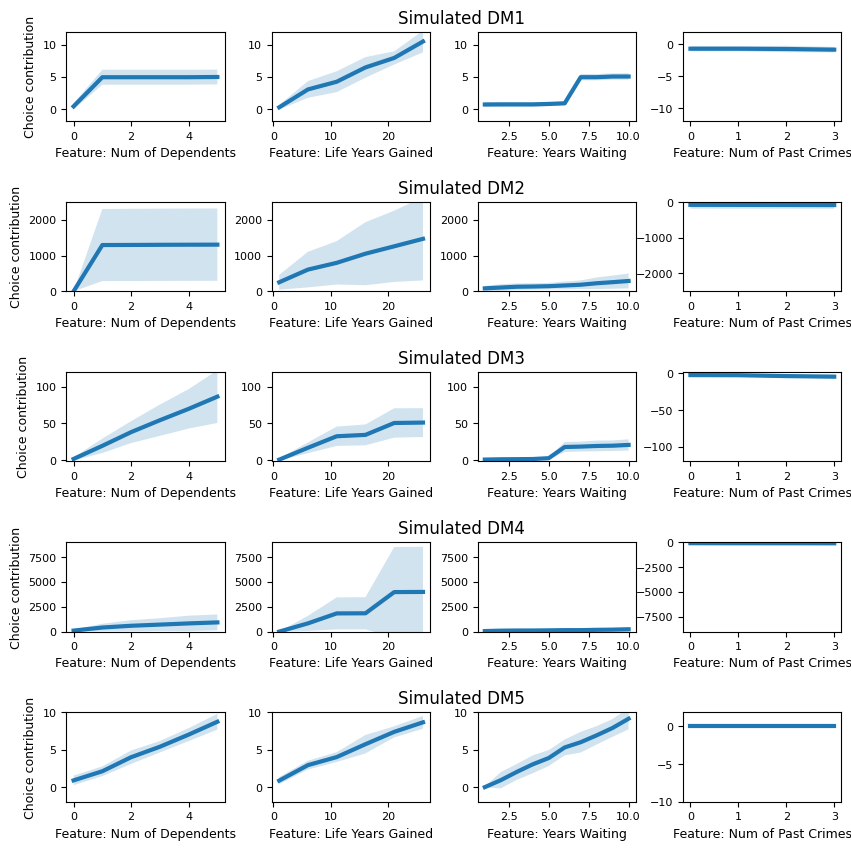

In [ ]:
plt.figure(figsize=(26, 10), dpi=100)
feat_to_print_names = {'dependents': 'Num of Dependents', 'life_gained': 'Life Years Gained', 'years_waiting': 'Years Waiting', 'crimes': 'Num of Past Crimes'}

fig, axs = plt.subplots(5, 4, figsize=(10, 10), dpi=100)
lims = [[12], [2500], [120], [9000], [10]]

for dm in range(1,6):
    # plt.subplot(150+dm)
    fs = np.array(list(range(10)))*10 + dm

    for i in range(4):
        # ax = plt.subplot(131+i)
        ax = axs[dm-1, i]
        rules = [factors_by_user[user][0].ir[i] for user in fs]
        xs = rules[0].fvalues
        vars = [rule.fsign * np.array(rule.get_vars()) for rule in rules]
        ys = np.mean(vars, axis=0)
        es = np.std(vars, axis=0)
        ax.plot(xs, ys, linewidth=3)
        ax.fill_between(xs, ys-es, ys+es, alpha=0.2)

        if i == 0:
            ax.set_ylabel("Choice contribution", fontsize=9)
        ax.set_xlabel("Feature: "+feat_to_print_names[rules[0].fname], fontsize=9)

        if i<3:
            ax.set_ylim(-1.9, lims[dm-1][0])
        else:
            ax.set_ylim(-lims[dm-1][0], 1.9)

        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=8)

        if i==1:
            ax.set_title("Simulated DM"+str(dm), x=1.2)

plt.subplots_adjust(wspace=0.3, hspace=0.9)
plt.savefig('images/editing_rules_simulated.png', bbox_inches='tight')
plt.show()


### Performance of our model and baselines for different dataset sizes

In [97]:
import warnings
warnings.filterwarnings("ignore")

interactions = False
results = []
verbose = False

baseline_models = {
            'ElasticNet': LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5),
            'DecisionTreeClassifier': DecisionTreeClassifier(),
            'RandomForestClassifier': RandomForestClassifier(),
            'MLPClassifier': MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000),
            'LinearSVC': LinearSVC(),
            'kNN': KNeighborsClassifier()
    }

for user in tqdm(users):
    df_user = df_lim[df_lim[idvar]==user]   
    
    reps = 1
    df_user_train_all, df_user_test = train_test_split(df_user, test_size=0.5, shuffle=True)
    for sz in np.linspace(10, 100, 10):
        df_user_train = df_user_train_all[:int(sz)]
        df_user_train, df_user_val = df_user_train, df_user_train

        model = LGClassifier(cols=main_cols, prefixes=[lprefix, rprefix], verbose=verbose)
        try:
            model.fit(df_user_train)
        except:
            ## exceptions mainly here arise here small datasets have only elements from one class label - best to just ignore this rep and start with another random split 
            continue
        acc = model.score(df_user_test)

        results.append([user, sz, "LogisticClf", acc])
        ### to fix later
        main_features = sorted(model.coefs, key=lambda x: np.abs(model.coefs[x]), reverse=True)[:1] 
        ###


        cols = [lprefix+c for c in main_cols] + [rprefix+c for c in main_cols]

        for name, model in baseline_models.items():
            model.fit(df_user_train[cols], df_user_train['chosen'])
            acc = model.score(df_user_test[cols], df_user_test['chosen'])
            results.append([user, sz, name, acc])


        train_accs, test_accs, models = [], [], []
        for cond_feature in main_features:
            
            model = IsotonicFactorClassifier(interactions=interactions, cols=main_cols, 
                                                        feature_signs=feature_signs, feature_values=feature_values, feat_to_diff_feat=feat_to_diff_feat,
                                                        lambda1=.00, lambda2=0.00, 
                                                        cond_feature=cond_feature, prefixes=[lprefix, rprefix], verbose=verbose)

            model.fit(df_user_train)
            test_acc = model.score(df_user_test)
            train_acc = model.score(df_user_val)

            train_accs.append(train_acc)
            test_accs.append(test_acc)
            models.append(model)

            if verbose:
                print (model.score(df_user_train), train_acc)
                print (test_acc, "\n")
         
        results.append([user, sz, "Our two-stage model", test_accs[np.argmax(train_accs)]])

        # print (acc, test_accs[np.argmax(train_accs)])
        



  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
# results_by_train_size_study_one = pd.DataFrame(results, columns=["user", "frac", "name", "acc"])
# results_by_train_size_study_one.to_csv('output/results_by_train_size_study_one.csv')

# results_by_train_size_study_two = pd.DataFrame(results, columns=["user", "frac", "name", "acc"])
# results_by_train_size_study_two.to_csv('output/results_by_train_size_study_two.csv')

# results_by_train_size_sim = pd.DataFrame(results, columns=["user", "frac", "name", "acc"])
# results_by_train_size_sim.to_csv('output/results_by_train_size_sim.csv')



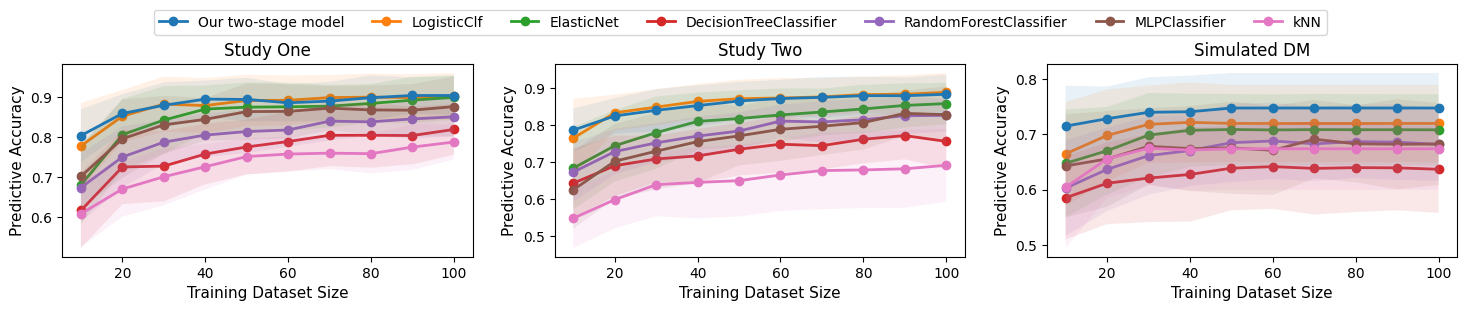

In [102]:
plt.figure(figsize=(18, 2.5))

mnames = ['Our two-stage model', 'LogisticClf', 'ElasticNet', 'DecisionTreeClassifier',
       'RandomForestClassifier', 'MLPClassifier', 'kNN', ]
order = [10] + [1]*6

res = [results_by_train_size_study_one, results_by_train_size_study_two, results_by_train_size_sim]
titles = ["Study One", "Study Two", "Simulated DM"]

for i, res_df in enumerate(res):

    plt.subplot(131+i)
    for j, name in enumerate(mnames):
        sub_df = res_df[res_df.name == name]
        # sub_df = results_by_train_size_study_one[results_by_train_size_study_one.name == name]
        xs = sub_df.frac.unique()
        ys = np.array([np.mean(sub_df[sub_df.frac==z].acc) for z in xs])
        es = np.array([np.std(sub_df[sub_df.frac==z].acc) for z in xs])

        # xs = [x*len(df_train_all)/10 for x in xs]

        plt.plot(xs, ys, "-o", label=name, linewidth=2, zorder=order[j])
        plt.fill_between(xs, ys-es, ys+es, alpha=0.1)


    plt.ylabel("Predictive Accuracy", fontsize=11)
    plt.xlabel("Training Dataset Size", fontsize=11)
    plt.title(titles[i])
        
plt.legend(ncol=7, bbox_to_anchor=(0.7,1.32))
plt.savefig('images/performance_by_training_size.pdf', bbox_inches='tight')

In [27]:
results_by_train_size_study_one.name.unique()

array(['LogisticClf', 'ElasticNet', 'DecisionTreeClassifier',
       'RandomForestClassifier', 'MLPClassifier', 'LinearSVC', 'kNN',
       'Our two-stage model'], dtype=object)